<a href="https://colab.research.google.com/github/zahraDehghanian97/Adversarially-Learned-Anomaly-Detection/blob/master/AE/AE_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


# **arythmia**

In [120]:
data = scipy.io.loadmat("/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection/data/arrhythmia.mat")
full_x_data = data["X"]
full_y_data = data['y']
x_train, x_test, y_train, y_test = train_test_split(full_x_data,full_y_data,test_size=0.2,random_state=42)

y_train = y_train.flatten().astype(int)
y_test = y_test.flatten().astype(int)
print("Scaling dataset")
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Scaling dataset


vanila AE

274
Epoch 1/20
3/3 [==============================] - 1s 69ms/step - loss: 0.1580 - val_loss: 0.1642
Epoch 2/20
3/3 [==============================] - 0s 15ms/step - loss: 0.1558 - val_loss: 0.1605
Epoch 3/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1512 - val_loss: 0.1539
Epoch 4/20
3/3 [==============================] - 0s 17ms/step - loss: 0.1436 - val_loss: 0.1440
Epoch 5/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1326 - val_loss: 0.1308
Epoch 6/20
3/3 [==============================] - 0s 15ms/step - loss: 0.1183 - val_loss: 0.1146
Epoch 7/20
3/3 [==============================] - 0s 20ms/step - loss: 0.1012 - val_loss: 0.0961
Epoch 8/20
3/3 [==============================] - 0s 15ms/step - loss: 0.0824 - val_loss: 0.0773
Epoch 9/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0637 - val_loss: 0.0603
Epoch 10/20
3/3 [==============================] - 0s 15ms/step - loss: 0.0478 - val_loss: 0.0472
Epoch 11/20
3/3 [========

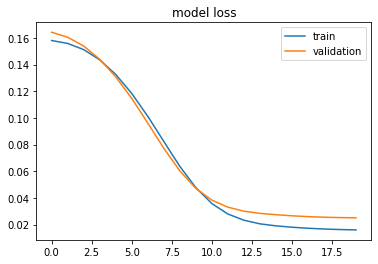

In [121]:
print(x_train.shape[1])
input_size = x_train.shape[1]
input_size = 274
hidden_size = 64
code_size = 8
epochs = 20
batch_size = 128

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size,name = "code_layer",activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)
# initialize
autoencoder = Model(inputs=x, outputs=r)
intermediate_layer_model = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer('code_layer').output)
autoencoder.compile(optimizer='adam', loss='mse')
# plot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
# train
history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, x_test))
# test
decoded_imgs = autoencoder.predict(x_test)
intermediate_output = intermediate_layer_model.predict(x_test)
print(intermediate_output.shape)
# loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plot histogram z = 8


(452, 274)


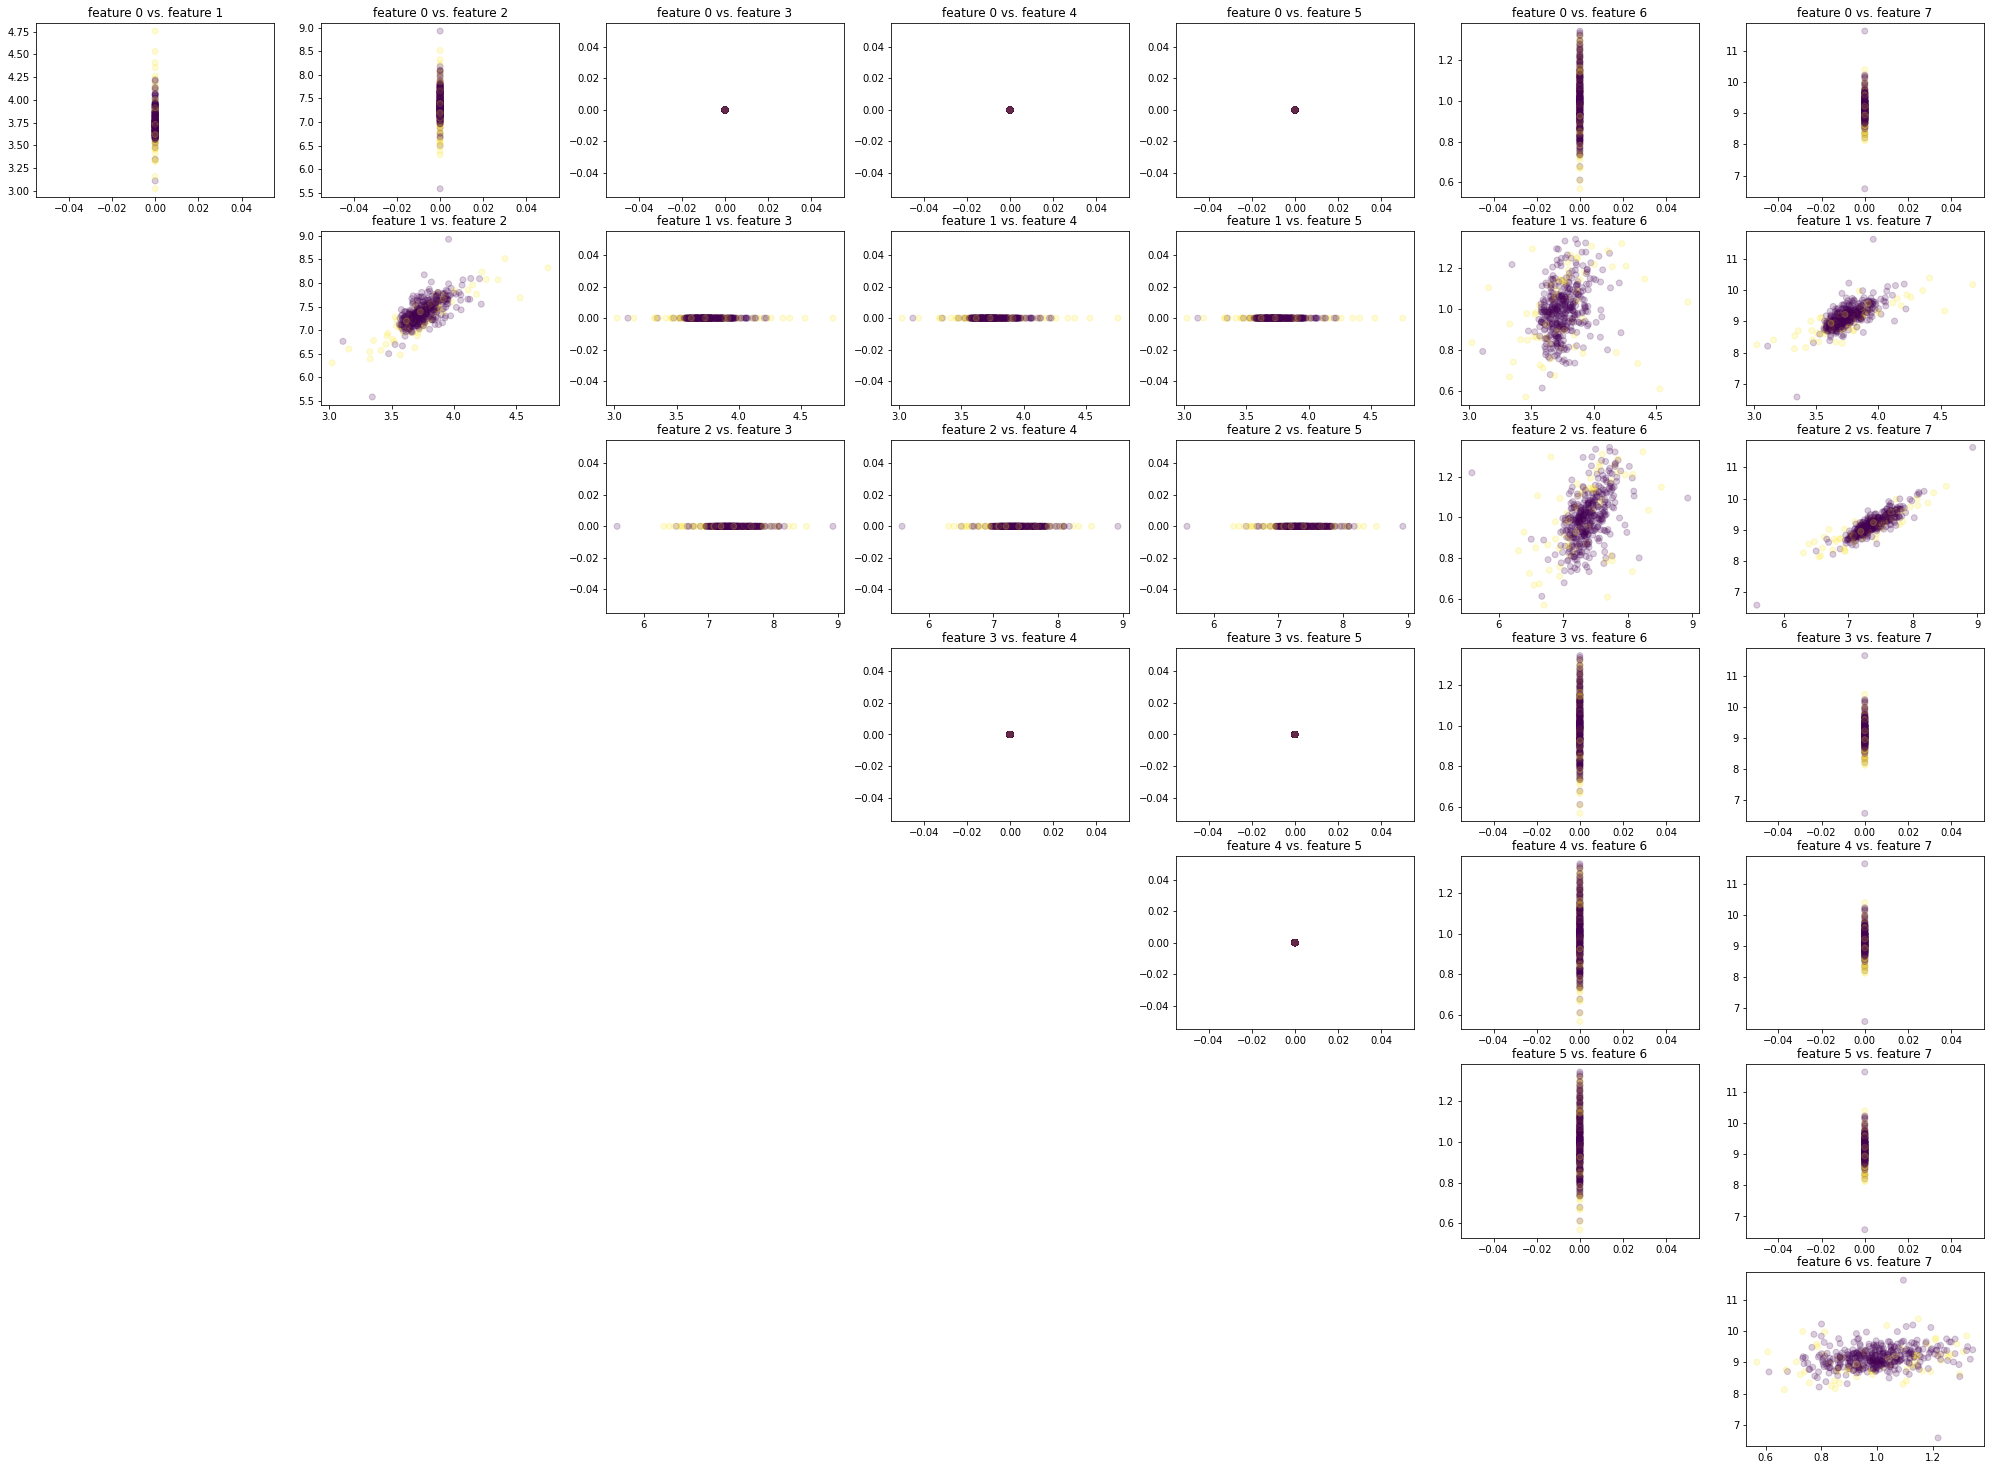

In [122]:
import matplotlib.gridspec as gridspec
alldata = np.concatenate((x_train,x_test), axis=0)
alllabel = np.concatenate((y_train,y_test))
print(alldata.shape)
code = intermediate_layer_model.predict(alldata)
fig = plt.figure(figsize=(40,30)) 
gs = gridspec.GridSpec(8, 8)
for i in range(code_size) :
  for j in range(i+1,code_size) :
    ax = plt.subplot(gs[i,j])
    ax.set_title("feature "+str(i)+" vs. feature "+str(j))
    ax.scatter(code[:, i], code[:, j], c=alllabel,alpha=0.2)
    fig.add_subplot(ax)
plt.show()


(452, 274)


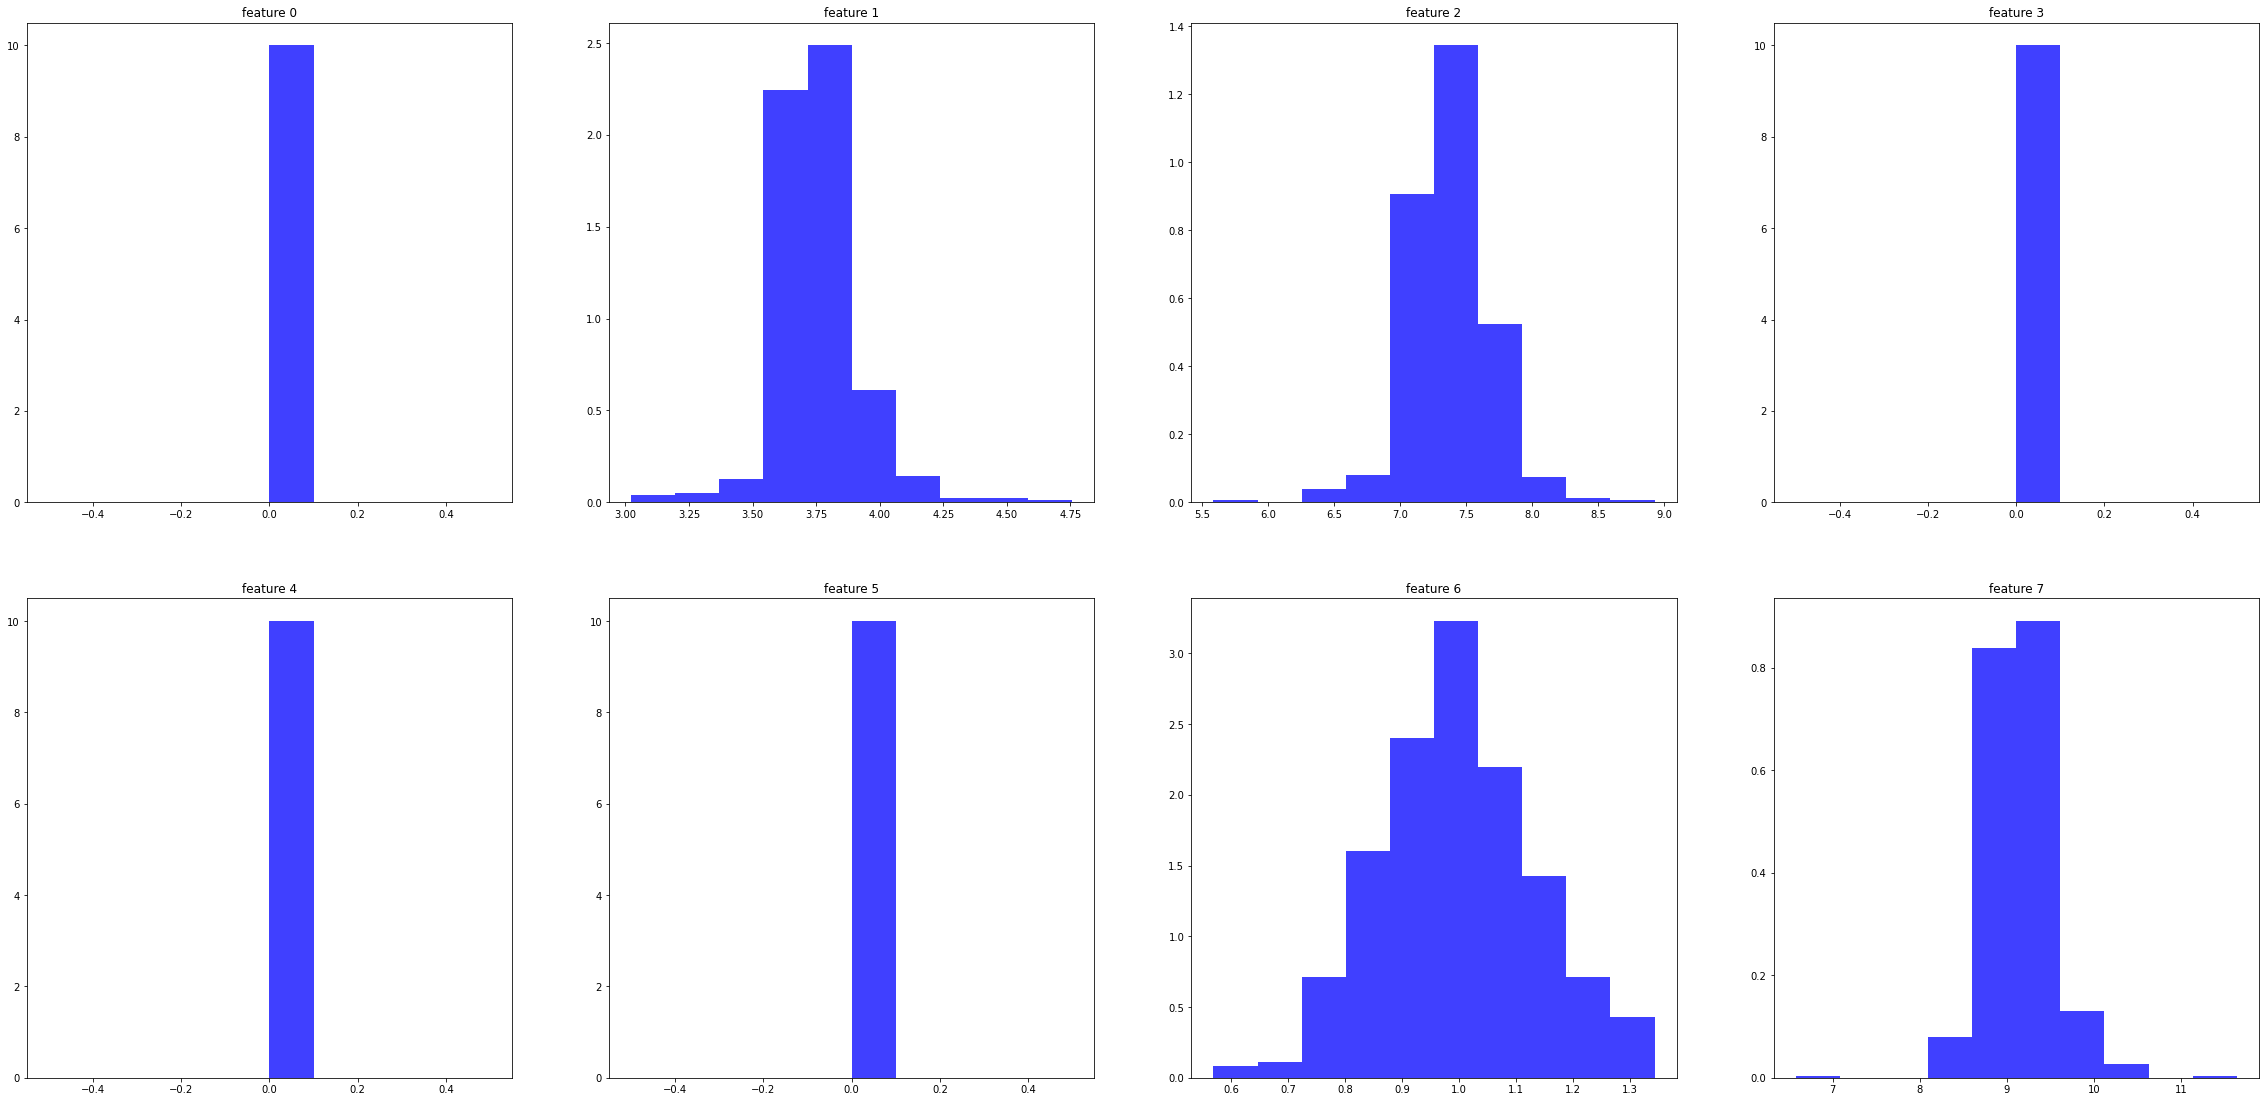

In [123]:
import matplotlib.gridspec as gridspec
alldata = np.concatenate((x_train,x_test), axis=0)
alllabel = np.concatenate((y_train,y_test))
print(alldata.shape)
code = intermediate_layer_model.predict(alldata)
fig = plt.figure(figsize=(40,30)) 
gs = gridspec.GridSpec(int(code_size/4)+1, 4)
for i in range(code_size) :
    ax = plt.subplot(gs[int(i/4),i%4])
    ax.set_title("feature "+str(i))
    ax.hist(code[:, i], 10, density=True, facecolor='b', alpha=0.75)
    fig.add_subplot(ax)
plt.show()

# **Diabetes**

In [124]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


10
Epoch 1/30
3/3 [==============================] - 1s 75ms/step - loss: 0.2499 - val_loss: 0.2517
Epoch 2/30
3/3 [==============================] - 0s 13ms/step - loss: 0.2485 - val_loss: 0.2502
Epoch 3/30
3/3 [==============================] - 0s 16ms/step - loss: 0.2470 - val_loss: 0.2487
Epoch 4/30
3/3 [==============================] - 0s 14ms/step - loss: 0.2455 - val_loss: 0.2471
Epoch 5/30
3/3 [==============================] - 0s 25ms/step - loss: 0.2439 - val_loss: 0.2455
Epoch 6/30
3/3 [==============================] - 0s 26ms/step - loss: 0.2423 - val_loss: 0.2438
Epoch 7/30
3/3 [==============================] - 0s 17ms/step - loss: 0.2407 - val_loss: 0.2421
Epoch 8/30
3/3 [==============================] - 0s 15ms/step - loss: 0.2390 - val_loss: 0.2403
Epoch 9/30
3/3 [==============================] - 0s 15ms/step - loss: 0.2372 - val_loss: 0.2384
Epoch 10/30
3/3 [==============================] - 0s 14ms/step - loss: 0.2353 - val_loss: 0.2365
Epoch 11/30
3/3 [=========

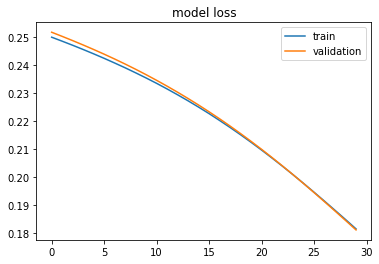

In [125]:
print(x_train.shape[1])
input_size = x_train.shape[1]
input_size = 10
hidden_size = 7
code_size = 4
epochs = 30
batch_size = 128

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size,name = "code_layer",activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)
# initialize
autoencoder = Model(inputs=x, outputs=r)
intermediate_layer_model = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer('code_layer').output)
autoencoder.compile(optimizer='adam', loss='mse')
# plot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
# train
history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, x_test))
# test
decoded_imgs = autoencoder.predict(x_test)
intermediate_output = intermediate_layer_model.predict(x_test)
print(intermediate_output.shape)
# loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plot histogram


(442, 10)


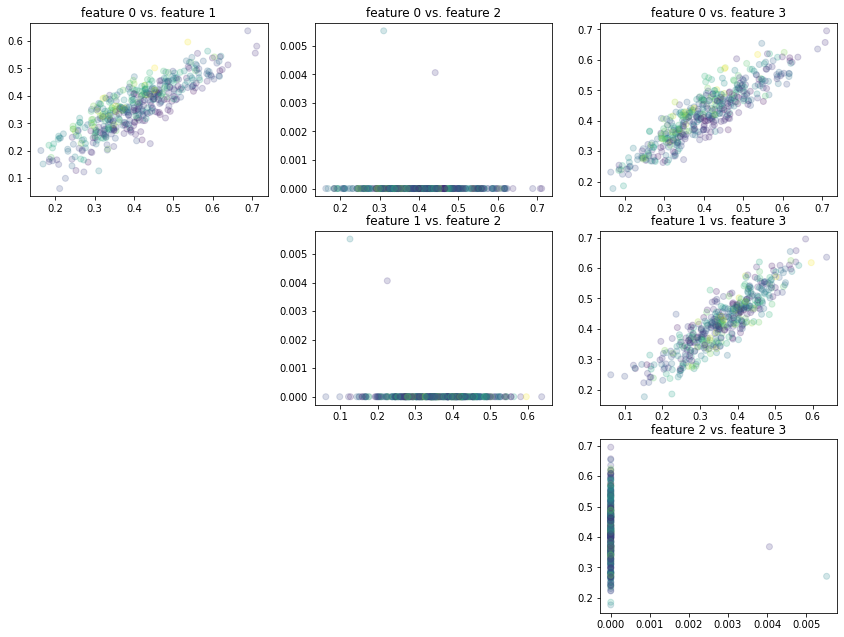

In [126]:
import matplotlib.gridspec as gridspec
alldata = np.concatenate((x_train,x_test), axis=0)
alllabel = np.concatenate((y_train,y_test))
print(alldata.shape)
code = intermediate_layer_model.predict(alldata)
fig = plt.figure(figsize=(40,30)) 
gs = gridspec.GridSpec(8, 8)
for i in range(code_size) :
  for j in range(i+1,code_size) :
    ax = plt.subplot(gs[i,j])
    ax.set_title("feature "+str(i)+" vs. feature "+str(j))
    ax.scatter(code[:, i], code[:, j], c=alllabel,alpha=0.2)
    fig.add_subplot(ax)
plt.show()


(442, 10)


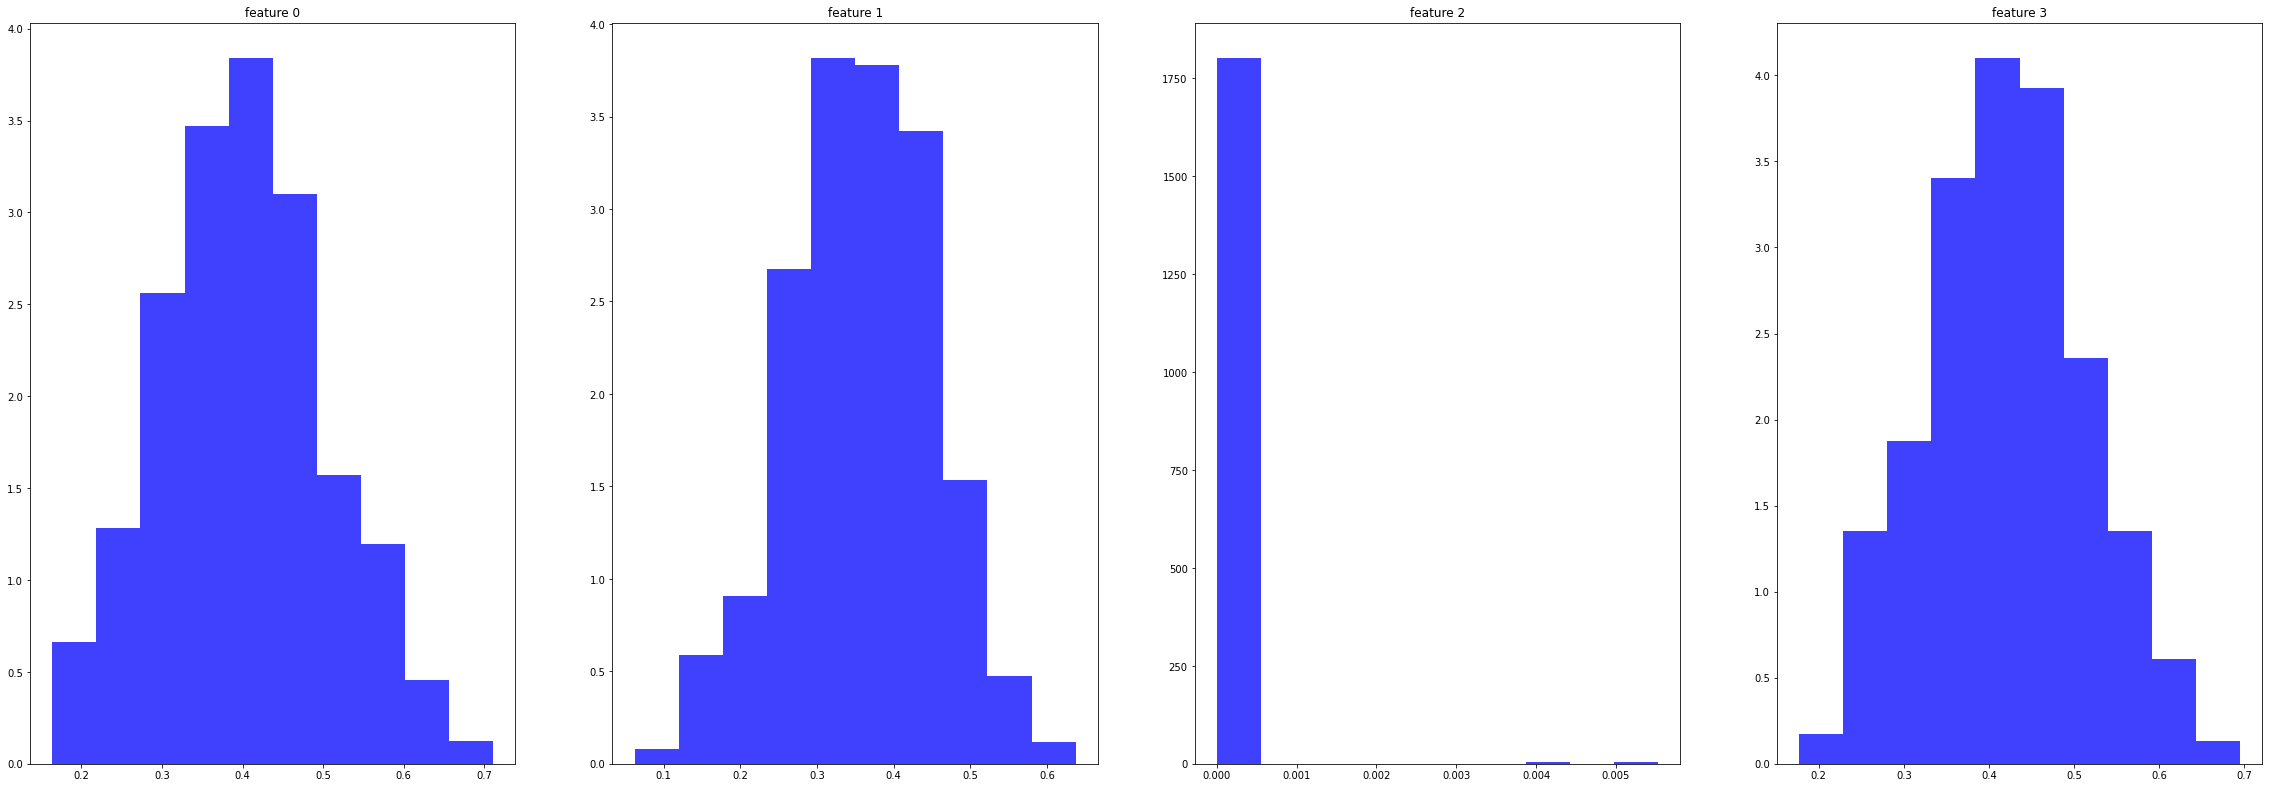

In [127]:
import matplotlib.gridspec as gridspec
alldata = np.concatenate((x_train,x_test), axis=0)
alllabel = np.concatenate((y_train,y_test))
print(alldata.shape)
code = intermediate_layer_model.predict(alldata)
fig = plt.figure(figsize=(40,30)) 
gs = gridspec.GridSpec(int(code_size/4)+1, 4)
for i in range(code_size) :
    ax = plt.subplot(gs[int(i/4),i%4])
    ax.set_title("feature "+str(i))
    ax.hist(code[:, i], 10, density=True, facecolor='b', alpha=0.75)
    fig.add_subplot(ax)
plt.show()